In [14]:
!pip install joblib requests

import numpy as np
import pandas as pd
import requests
import joblib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tensorflow import keras

# Load model & scalers
model = keras.models.load_model("weather_forecast_model.keras")
feat_scaler = joblib.load("feature_scaler.pkl")
cont_scaler = joblib.load("continuous_scaler.pkl")

print("✔ Model & Scalers Loaded")


✔ Model & Scalers Loaded


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [15]:
CONT_TARGETS = [
    "temperature_2m",
    "relative_humidity_2m",
    "surface_pressure",
    "wind_speed_10m",
    "precipitation"
]

FEATS = [
    'hour', 'dow', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
    'temperature_2m_rmean_6', 'temperature_2m_rstd_6', 'temperature_2m_rmean_24', 'temperature_2m_rstd_24',
    'relative_humidity_2m_rmean_6', 'relative_humidity_2m_rstd_6', 'relative_humidity_2m_rmean_24', 'relative_humidity_2m_rstd_24',
    'surface_pressure_rmean_6', 'surface_pressure_rstd_6', 'surface_pressure_rmean_24', 'surface_pressure_rstd_24',
    'wind_speed_10m_rmean_6', 'wind_speed_10m_rstd_6', 'wind_speed_10m_rmean_24', 'wind_speed_10m_rstd_24',
    'precipitation_rmean_6', 'precipitation_rstd_6', 'precipitation_rmean_24', 'precipitation_rstd_24',
    'temperature_2m', 'relative_humidity_2m', 'surface_pressure', 'wind_speed_10m', 'precipitation'
]


In [16]:
def fetch_weather(lat, lon, days=5, tz="UTC"):
    end = datetime.utcnow().date().isoformat()
    start = (datetime.utcnow() - timedelta(days=days)).date().isoformat()

    BASE = "https://archive-api.open-meteo.com/v1/era5"
    VARS = ",".join([
        "temperature_2m","relative_humidity_2m","surface_pressure","wind_speed_10m","precipitation",
        "dew_point_2m","cloudcover","cloudcover_low","cloudcover_mid","cloudcover_high",
        "wind_gusts_10m","cape"
    ])

    r = requests.get(BASE, params={
        "latitude": lat, "longitude": lon,
        "start_date": start, "end_date": end,
        "timezone": tz, "hourly": VARS
    })
    r.raise_for_status()

    df = pd.DataFrame(r.json()["hourly"])
    df["datetime"] = pd.to_datetime(df["time"])
    df = df.set_index("datetime").drop(columns=["time"]).asfreq("h")
    return df.ffill().bfill()


In [17]:
def prepare_features(df):
    df = df.copy()

    # time features
    df["hour"] = df.index.hour
    df["dow"] = df.index.dayofweek
    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
    df["dow_sin"]  = np.sin(2*np.pi*df["dow"]/7)
    df["dow_cos"]  = np.cos(2*np.pi*df["dow"]/7)

    # rolling stats
    for col in ["temperature_2m","relative_humidity_2m","surface_pressure","wind_speed_10m","precipitation"]:
        df[f"{col}_rmean_6"]  = df[col].rolling(6, min_periods=1).mean()
        df[f"{col}_rstd_6"]   = df[col].rolling(6, min_periods=1).std().fillna(0)
        df[f"{col}_rmean_24"] = df[col].rolling(24, min_periods=1).mean()
        df[f"{col}_rstd_24"]  = df[col].rolling(24, min_periods=1).std().fillna(0)

    return df


In [18]:
LOOKBACK = 72
HORIZON = 72

def predict_weather(lat, lon, rain_threshold=0.35):
    df = fetch_weather(lat, lon)
    df = prepare_features(df)

    X = df[FEATS].values[-LOOKBACK:]
    Xs = feat_scaler.transform(X).reshape(1, LOOKBACK, -1)

    cont_s, rain_prob = model.predict(Xs, verbose=0)

    cont = cont_scaler.inverse_transform(cont_s.reshape(-1, len(CONT_TARGETS))).reshape(cont_s.shape)
    rain_prob = rain_prob[0,:,0]
    rain_yes = (rain_prob >= rain_threshold).astype(int)

    future = pd.date_range(df.index[-1], periods=HORIZON, freq="h")

    return future, cont[0], rain_prob, rain_yes


/tmp/ipython-input-833567097.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end = datetime.utcnow().date().isoformat()
/tmp/ipython-input-833567097.py:3: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start = (datetime.utcnow() - timedelta(days=days)).date().isoformat()


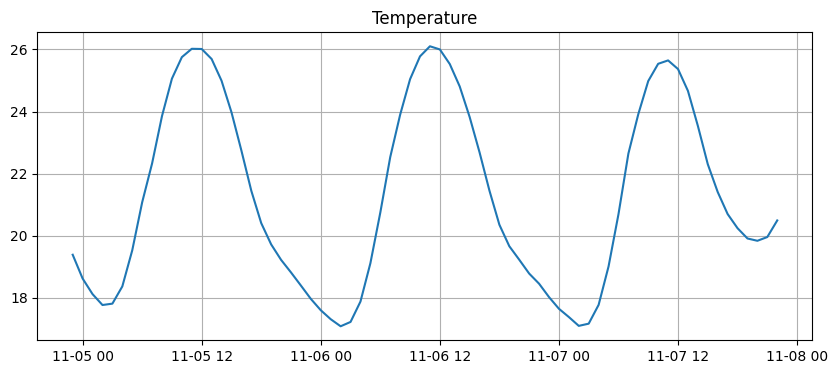

In [21]:
future, cont, prob, rain = predict_weather(12.9716, 77.5946)  # Bangalore

plt.figure(figsize=(10,4))
plt.plot(future, cont[:,0])
plt.title("Temperature")
plt.grid(True)
plt.show()
